# Machine Learning Project to Learn The Games of Dots

*By Asif Anwar Baig Mirza, May 9 2018*

### Reinforcement Learning for Two Player Games

## Introduction

The state is the board configuration. There are  $2^{20} + 2^{20} + 3^{16}$  of them, not all are reachable. 
The number adds up to 44,095,337
This number is way too big for us to run all of the combinations or even half of the combination. However, the system learns the combination which are repetitive, for example the first move can be learnt. However, we cannot determine if the first move learnt is a good move or not. 

We use a dictionary to represent the Q table with a key and a value, where key is the current state and the value is the move which the we have made to reach the next state, a 0 is assigned if that value has led to a draw, and a 1 is assigned if we win. We assign a -1 when ever the opponent wins a point in the game.

We also assign a constant error and try to adjust our values accordingly so that we are learning continously from a bad move.

There are total of 16 points to win in one game and if a player wins more than 8 points it wins the game. We have designed the game to win as many points as possible within a game and when ever we encounter a win we update out table and if we don't have a table of Q we create a table of Q and update the respective value. 

#### How to Play The Game

Once a player is given a chance to play, the Player can play either a line or a dash. Once a box has been created the player who created the box gets a point and most number of points lead to win at the board. This is a cumulative game where the result of who won is know by all the points they have acquired playing during a game and every point they have acquired is stored and used to learn continously.  

There also a move where the player who has won a point gets an other chance to make a move hence giving him an advantage if he is close to winning.

There are very rare cases of a game ending in a Draw. 

We have represented the board using dash(-) and a vertical line(|). An empty board would look as follows. 



       .  .  .  .  .
        $  $  $  $
       .  .  .  .  .
        $  $  $  $
       .  .  .  .  .
        $  $  $  $
       .  .  .  .  .
        $  $  $  $
       .  .  .  .  .

And a completely filled up board would look as follows.

     .--.--.--.--.
     |O |X |O |X | 
     .--.--.--.--.
     |X |O |O |X |
     .--.--.--.--.
     |X |O |O |X | 
     .--.--.--.--.
     |X |X |O |O |
     .--.--.--.--.
     
In this particular situtaition Player X has won the game.

We represent the empty boxes with '$' so that we know that's not a valid move to make however, it's essential to read the value X or O since the characted drawn after the move has been made is essential to assign points. 

Here X is the learning player and O is just a random player. 


## Method

We implement the method of Reinforcement Learning.

Reinforcement Learning is a reward based learning where the algorithm explores all the possibilities and when it has made a right decision it's given a reward for making the right decision. In our case for doing the right move it has acquired a point (1). 

Reinforcement is like a baby trying to walk for the first time. The baby has to know how to stand first inorder to walk and to be able to stand the baby has to use the right muscles in the body and use the sense of balance to make sure he is able to stand properly with a support and whitout a support first, Once the baby has learnd to walk it has to make the next step towards moving his legs and arms and head in a way that he moves forward. During this whole process the baby falls a lot times before actually being able to stand and then next being able to walk properly. 

We use the exact same method for the system to learn to win games. The idea to teach the game to win points instead of a whole game, winning more number of points gives a win in the game. As mentioned above there are about 44Million possibilities which can occour and 44Million possibilities to learn the whole of the game. Once we have a knowledge of atleast more than half of the possibilities we should be able to make correct and adaptive decisions so as to win every possible game. 

In [251]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from copy import copy
import random
import sys

from IPython.display import display, clear_output

This function is to make sure that we represent our board as it is supposed to look 

In [301]:
def printBoard(board):
    print('''
.{}.{}.{}.{}.
{}{}{}{}{}{}{}{}{}
.{}.{}.{}.{}.
{}{}{}{}{}{}{}{}{}
.{}.{}.{}.{}.
{}{}{}{}{}{}{}{}{}
.{}.{}.{}.{}.
{}{}{}{}{}{}{}{}{}
.{}.{}.{}.{}.'''.format(*tuple(board)))
          

    PlotOutcomes
This function is used to make sure that the graph we are drawing looks like it's supposed to and we are plotting number of wins player X has won and lost and if there are any draws if there is any draw.

In [302]:
def plotOutcomes(outcomes,epsilons,maxGames,nGames):
    if nGames==0:
        return
    nBins = 100
    nPer = int(maxGames/nBins)
    outcomeRows = outcomes.reshape((-1,nPer))
    outcomeRows = outcomeRows[:int(nGames/float(nPer))+1,:]
    avgs = np.mean(outcomeRows,axis=1)
    plt.subplot(3,1,1)
    xs = np.linspace(nPer,nGames,len(avgs))
    plt.plot(xs, avgs)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes\n(0=draw, 1=X win, -1=O win)')
    plt.title('Bins of {:d} Games'.format(nPer))
    plt.subplot(3,1,2)
    plt.plot(xs,np.sum(outcomeRows==-1,axis=1),'r-',label='Losses')
    plt.plot(xs,np.sum(outcomeRows==0,axis=1),'b-',label='Draws')
    plt.plot(xs,np.sum(outcomeRows==1,axis=1),'g-',label='Wins')
    plt.legend(loc="center")
    plt.ylabel('Number of Games\nin Bins of {:d}'.format(nPer))
    plt.subplot(3,1,3)
    plt.plot(epsilons[:nGames])
    plt.ylabel('$\epsilon$')

This function helps us make our move which helps us learn and predict the next move. In the start, our moves are completely random and we are still making steps to learn which ones are the good moves and which ones are not. Once we have made quite a number of moves (based on the epsilon value) we decide that we have learnt the algorithm and start using our Q function to check if we have already made the same move in the past and iteratively learn from the move we have already made. 

In [303]:
def epsilonGreedy(epsilon, Q, board):
    validMoves = np.where(board == ' ')[0]
    if np.random.uniform() < epsilon:
        # Random Move
        return np.random.choice(validMoves)
    else:
        # Greedy Move
        np.random.shuffle(validMoves)
        Qs = np.array([Q.get((tuple(board),m), 0) for m in validMoves]) 
        return validMoves[ np.argmax(Qs) ]

    Move
This function decides if a dash has to be inserted or a line has to be inserted, we cannot insert everything everywhere hence this function helps us make a correct decision. 

In [304]:
def Move(move):
    if ((move==0) |(move==1) |(move==2) |(move==3) |(move==13)|(move==14)|(move==15)|(move==16)|
        (move==26)|(move==27)|(move==28)|(move==29)|(move==39)|(move==40)|(move==41)|(move==42)|
        (move==52)|(move==53)|(move==54)|(move==55)):
        return('-')
    
    elif((move==4)|(move==6) |(move==8) |(move==10)|(move==12)|(move==17)|(move==19)|(move==21)|
        (move==23)|(move==25)|(move==30)|(move==32)|(move==34)|(move==36)|(move==38)|(move==43)|
        (move==45)|(move==47)|(move==49)|(move==51)):
        return('|')
    
    else:
        return('$')

    point
The point function assigns the value X or O in the table once a matching combination is detected by the board. There are total of 16 possible combination which can get a point (i.e. the name X or O inside the table.) In order to avoid redundancy on the writing if a combination has already been detected we are skipping the combination and continuing with next step. This helps us count one possibility only once. Returning the board state with updated value once we have made decision, i.e. either there is a update or no update or none of the conditions satisfy.

In [305]:
# This function just gives a point for a valid move made.
def point(check, Player, board): #Incomplete, have to return to a function with updated values.
    Point = False
    Temp_board = board
    Empty_Spaces = (5,7,9,11,18,20,22,24,31,33,35,37,44,46,48,50)
    Combo = np.array((0, 4, 6, 13, # no relation with anything else 
                   1, 6, 8, 14, 
                   2, 8, 10, 15, 
                   3, 10, 12, 16,
                   13, 17, 19, 26,
                   14, 19, 21, 27,
                   15, 21, 23, 28,
                   16, 23, 25, 29,
                   26, 30, 32, 39,
                   27, 32, 34, 40,
                   28, 34, 36, 41,
                   29, 36, 38, 42,
                   39, 43, 45, 52,
                   40, 45, 47, 53,
                   41, 47, 49, 54,
                   42, 49, 51, 55)).reshape(-1,4)

    for i in range(len(Combo)-1):
        if(np.array_equal(check,Combo[i]) == True):
            Point_At = i
            Fill = Empty_Spaces[Point_At]
            
            if((Temp_board[Fill]=='X')or(Temp_board[Fill]=='O')):
                Point = False
                return(Point,Temp_board)
                    
            Temp_board[Fill]= Player
            Point = True
            #printBoard(Temp_board)
            #sys.exit("Enters the True state")
            return (Point, Temp_board)
        
    return (Point, Temp_board)        

    pointCheck
Once we have a valid move on the board, this function is called to check if at all there is a possibility of getting a point on the table. There are totally 4 ways to check if we have a point, which is from top to bottom, bottom to top, left to right, and right to left. If a dash is detected there are 2 possibilities which are either there can be a box detected above the dash or below the dash, similarly when a line is detected there is possibility that a box can be detected on the left or the right of the line, and this function checks all these possibilities.  

In [306]:
def pointCheck(board, Player):
    #print('Hey, I am here')
    #Have to change this value to make it work !!! 
    # it has to make sure that you have all the veritcal and dashes to record an entry.
    Result = False
    Player = Player
    board = board
    
    for i in range(0,43):
        if (board[i]=='-'): # Detecting the dash up to down
            var = i
            x = int(var%13)
            y = int(var/13)
            if(x ==0):
                if ((board[var+4] == '|') & (board[var+6]=='|') & (board[var+13]=='-')):
                    #print(var,var+4,var+6,var+13) # write a function to get a point and get out. !!
                    Result, board =point(np.array([var,var+4,var+6,var+13]), Player, board)
                    #return(Result, board)
            if(x ==1):
                if ((board[var+5] =='|') & (board[var+7]=='|') & (board[var+13]=='-')):
                    Result, board =point(np.array([var,var+5,var+7,var+13]), Player, board)
                    #return(Result, board)
            if(x ==2):
                if ((board[var+6] =='|') & (board[var+8]=='|') & (board[var+13]=='-')):
                    Result, board =point(np.array([var,var+6,var+8,var+13]), Player, board)
                    #return(Result, board)
            if(x ==3):
                if ((board[var+7] =='|') & (board[var+9]=='|') & (board[var+13]=='-')):
                    Result, board =point(np.array([var,var+7,var+9,var+13]), Player, board)
                    #return(Result, board)
            #return(Result, board)
                    
    for i in range(55,12):
        if (board[i]=='-'): # Detecting the dash down to up
            var = i
            x = int(var%13)
            y = int(var/13)
            if(x ==0):
                if ((board[var-9] == '|') & (board[var-7]=='|') & (board[var-13]=='-')):
                    #print(var,var+4,var+6,var+13) # write a function to get a point and get out. !!
                    Result, board =point(np.array([var-13,var-9,var-7,var]), Player, board)
                    #return(Result, board)
            if(x ==1):
                if ((board[var-8] =='|') & (board[var-6]=='|') & (board[var-13]=='-')):
                    Result, board =point(np.array([var-13,var-8,var-6,var]), Player, board)
                    #return(Result, board)
            if(x ==2):
                if ((board[var-7] =='|') & (board[var-5]=='|') & (board[var-13]=='-')):
                    Result, board =point(np.array([var-13,var-7,var-5,var]), Player, board)
                    #return(Result, board)
            if(x ==3):
                if ((board[var-6] =='|') & (board[var-4]=='|') & (board[var-13]=='-')):
                    Result, board =point(np.array([var-13,var-6,var-4,var]), Player, board)
                    #return(Result, board)
        
            #return(Result, board)
    
    for i in range(0,43):
        if (board[i]=='|'): # Detecting the line back to front
            var = i
            x = int(var%13)
            y = int(var/13)
            if(x ==0):
                if ((board[var-4] == '-') & (board[var+2]=='|') & (board[var+9]=='-')):
                    #print(var,var+4,var+6,var+13) # write a function to get a point and get out. !!
                    Result, board =point(np.array([var-4,var,var+2,var+9]), Player, board)
                    #return(Result, board)
            if(x ==1):
                if ((board[var-5] =='-') & (board[var+2]=='|') & (board[var+8]=='-')):
                    Result, board =point(np.array([var-5,var,var+2,var+8]), Player, board)
                    #return(Result, board)
            if(x ==2):
                if ((board[var-6] =='-') & (board[var+2]=='|') & (board[var+7]=='-')):
                    Result, board =point(np.array([var-6,var,var-5,var+7]), Player, board)
                    #return(Result, board)
            if(x ==3):
                if ((board[var-7] =='-') & (board[var+2]=='|') & (board[var+6]=='-')):
                    Result, board =point(np.array([var-7,var,var-4,var+6]), Player, board)
                    #return(Result, board)
            #return(Result, board)

    for i in range(55,12):
        if (board[i]=='|'): # Detecting the line front to back
            var = i
            x = int(var%13)
            y = int(var/13)
            if(x ==0):
                if ((board[var-6] == '-') & (board[var-2]=='|') & (board[var+7]=='-')):
                    #print(var,var+4,var+6,var+13) # write a function to get a point and get out. !!
                    Result, board =point(np.array([var-6,var-2,var,var+7]), Player, board)
                    #return(Result, board)
            if(x ==1):
                if ((board[var-7] =='-') & (board[var-2]=='|') & (board[var+6]=='-')):
                    Result, board =point(np.array([var-7,var-2,var,var+6]), Player, board)
                    #return(Result, board)
            if(x ==2):
                if ((board[var-8] =='-') & (board[var-2]=='|') & (board[var+5]=='-')):
                    Result, board =point(np.array([var-8,var-2,var,var+5]), Player, board)
                    #return(Result, board)
            if(x ==3):
                if ((board[var-9] =='-') & (board[var-2]=='|') & (board[var+4]=='-')):
                    Result, board =point(np.array([var-9,var-2,var,var+4]), Player, board)
            #return(Result, board)
    return(Result, board)

###### MAIN FUNCTION

This is where we test all the defined functions above. 

Outcomes: 1976 X wins 2024 O wins 0 draws


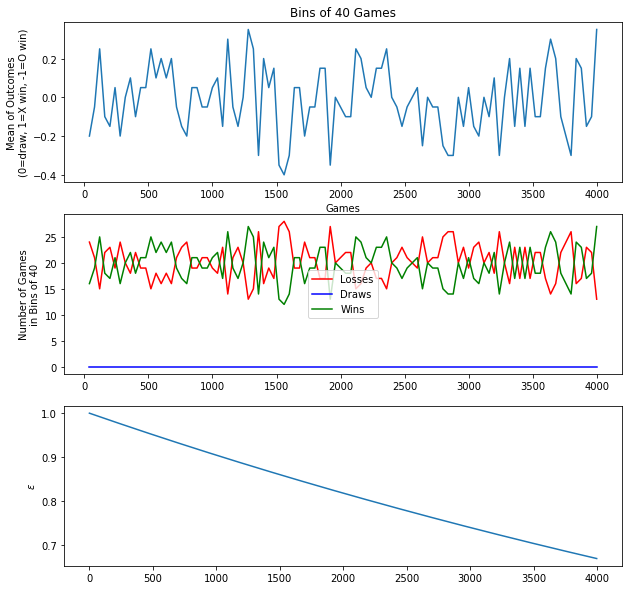

In [326]:
maxGames = 4000
rho = 0.5
epsilonDecayRate = 0.9999
epsilon = 1.0
graphics = True
showMoves = not graphics

outcomes = np.zeros(maxGames)
epsilons = np.zeros(maxGames)
Q = {}
Points = False



if graphics:
    fig = plt.figure(figsize=(10,10))
    
for nGames in range(maxGames):
    epsilon *= epsilonDecayRate
    epsilons[nGames] = epsilon
    step = 0
    #My Empty Board
    Win_X = 0
    Win_O = 0
    board = np.array([ ' ', ' ', ' ', ' '# This is the dashes -1
                     , ' ', '$', ' ', '$', ' ', '$', ' ', '$', ' '# This is the vertical + Name -1
                     , ' ', ' ', ' ', ' '# This is dashes -2
                     , ' ', '$', ' ', '$', ' ', '$', ' ', '$', ' '# This is vertical + Name -2
                     , ' ', ' ', ' ', ' '# This is dashes -3
                     , ' ', '$', ' ', '$', ' ', '$', ' ', '$', ' '# This is vertical + Name -3
                     , ' ', ' ', ' ', ' '# This is dashes -4
                     , ' ', '$', ' ', '$', ' ', '$', ' ', '$', ' '# This is verical + Name -4
                     , ' ', ' ', ' ', ' '# This is dashes -5
                     ])
    #defining a few variables.
    done = False
    Count =0
    True_X =0
    isTrue_X = False
    True_O =0
    isTrue_O = False
    Count_X_temp =0
    Count_O_temp =0
    Count_X =0
    Count_O =0
    while not done: 
        
        step += 1
        
        # X plays first 
        boardNew = copy(board)
        move = epsilonGreedy(epsilon, Q, board)
        
        boardNew[move] = Move(move)
        
        
        if (tuple(board),move) not in Q:
            Q[(tuple(board),move)] = 0  # initial Q value for new board,move
            
        if showMoves:
            printBoard(boardNew)
        #return new state of the board      
        Points, boardNew = pointCheck(boardNew,'X')
        
        Uni_X = np.unique(boardNew,return_counts =True)
        for i in range(len(Uni_X[0])):
            if(Uni_X[0][i]=='X'):
                Count_X_temp = Uni_X[1][i]
                
        if (Count_X != Count_X_temp):
            Count_X =Count_X_temp
            isTrue_X = True
        
        if ((Count_X + Count_O == 16)):#checking if it's a draw
            # Game over. No winner.
            Q[(tuple(board),move)] = 0
            done = True
            outcomes[nGames] = 0
            continue
        
        
        if (isTrue_X == True):
            isTrue_X = False
            Q[(tuple(board),move)] = 1
            #print('Number of X wins is:',Count_X)
            if Count_X >7:
                done = True
                outcomes[nGames] = 1
            
            if step > 1:
                Q[(tuple(boardOld),moveOld)] += rho * (Q[(tuple(board),move)] - Q[(tuple(boardOld),moveOld)])
            
            boardOld, moveOld = board, move # remember board and move to Q(board,move) can be updated after next steps
            board = boardNew
            continue
            
        if ((Count_X + Count_O == 16)):
            # Game over. No winner.
            Q[(tuple(board),move)] = 0
            done = True
            outcomes[nGames] = 0
        
        else :
            # O's turn.  O is a random player!
            O_Win = True
            while(O_Win == True):
                #printBoard(boardNew)
                moveO = np.random.choice(np.where(boardNew==' ')[0])
                #including Dash or Line from the function. 
                boardNew[moveO] = Move(moveO)
                Points, boardNew = pointCheck(boardNew,'O')
                Uni_O = np.unique(boardNew,return_counts =True)
                for i in range(len(Uni_O[0])):
                    if(Uni_O[0][i]=='O'):
                        Count_O_temp = Uni_O[1][i]
                
                if (Count_O != Count_O_temp):
                    Count_O =Count_O_temp
                    isTrue_O = True
                
                if ((Count_X + Count_O == 16)):
                    # Game over. No winner.
                    Q[(tuple(board),move)] = 0
                    done = True
                    outcomes[nGames] = 0
                    continue
                
                
                if (isTrue_O == True):
                    isTrue_O =False
                    # O won!
                    if (tuple(board),move) not in Q:#creating a new entry in the table
                        Q[(tuple(board),move)] = 0
                    Q[(tuple(board),move)] += rho * (-1 - Q[(tuple(board),move)])
                    
                    if (Count_O >7):
                        outcomes[nGames] = -1
                        done = True
                        O_Win = False

        
                    if step > 1:
                        Q[(tuple(boardOld),moveOld)] += rho * (Q[(tuple(board),move)] - Q[(tuple(boardOld),moveOld)])
            
                    boardOld, moveOld = board, move # remember board and move to Q(board,move) can be updated after next steps
                    board = boardNew
                    continue
                    
                O_Win = False
                continue
                
        if (tuple(board),move) not in Q:
            Q[(tuple(board),move)] = 0  # initial Q value for new board,move
            
        if step > 1:
            Q[(tuple(boardOld),moveOld)] += rho * (Q[(tuple(board),move)] - Q[(tuple(boardOld),moveOld)])
            
        boardOld, moveOld = board, move # remember board and move to Q(board,move) can be updated after next steps
        board = boardNew
        
        #printing graphics
        if graphics and (nGames % (maxGames/10) == 0 or nGames == maxGames-1):
            fig.clf() 
            plotOutcomes(outcomes,epsilons,maxGames,nGames-1)
            clear_output(wait=True)
            display(fig);

if graphics:
    clear_output(wait=True)
print('Outcomes: {:d} X wins {:d} O wins {:d} draws'.format(np.sum(outcomes==1), np.sum(outcomes==-1),
                                                            np.sum(outcomes==0)))

There might be disturbancies in the number wins since we are probably kind of making X learn a few of the possibilities from 44Million possible moves. Not everytime it might give more number of wins for small values. 

In [315]:
printBoard(board)


.-.-.-.-.
|X|O|O|O|
.-.-.-.-.
|O|X|O|O|
.-.-.-.-.
|$|X|O|O|
. .-.-.-.
|$|O|$ $|
.-.-.-.-.


In [321]:
board_x =('-','-',' ',' ','|','$',' ','$',' ','$','|','$','|','-','-','-',' ','|','$',
           ' ','$',' ','$','|','$',' ','-','-','-',' ',' ','$','|','$','|','$',' ','$',
           ' ','-',' ','-','-',' ','$','|','$',' ','$','|','$','|','-','-',' ','-')
printBoard(board_x)
Q[(tuple(board_x),19)]
          


.-.-. . .
|$ $ $|$|
.-.-.-. .
|$ $ $|$ 
.-.-.-. .
 $|$|$ $ 
.-. .-.-.
 $|$ $|$|
.-.-. .-.


1.0

If the next move for the current state is 19, X always gets a point and hence a value of 1.0 is assigned and stored and if any time such move occours, X knows that he has to move to position 19 in order to maintain that 1.0 else it looses points and the max function is to make sure that X has the maximum number of points.

In [323]:
board_x1 =('-','-',' ',' ','|','X','|','X','|','$','|','$','|','-','-','-',' ','|','X','|','$',' ','$','|',
           '$',' ','-','-','-',' ',' ','$','|','X','|','$',' ','$',' ','-','-','-','-',' ','$','|','$',' ',
           '$','|','$','|','-','-',' ','-')
printBoard(board_x1)
Q[(tuple(board_x1),16)]



.-.-. . .
|X|X|$|$|
.-.-.-. .
|X|$ $|$ 
.-.-.-. .
 $|X|$ $ 
.-.-.-.-.
 $|$ $|$|
.-.-. .-.


-0.25

This particular move has caused O to gain a point and hence X looses a point and hence the -0.25 representing that X loosing the point. 

## References 

[1]. Lecture videos by Professor Chuck Anderson has helped a lot in designing the project.

[2]. Professors Chuck Anderson's lecture notes have been used and all the ideas and similartities have been adapted from him lecture notes.

[3]. Reinforcement Learning: An Introduction by Richard S. Sutton and Andrew G. Barto has been refered to explain reinforcement learning briefly.



### Acknowledgement 

I thank Professor Chuck Anderson for helping me with learning Machine Learning, and driving us to do this final project. There is still so much out there to learn and explore in this feild and I can't thank enough to Professor to make this a fun learning. 

### Future Work

I shall try implementing a second Q table to the O variable so that learning happens in both ways and see which one outperforms.

Shall also try implementing atleast 1 million games to see any significant learning.

Shall also try change the learning rate, epsilon values to see if it gives better results. 

*Please find the screenshot attachment for 100000 games*